# SDSC 2001 Final Project — Diabetes Health Indicators

In [490]:
import sys, subprocess
from pathlib import Path

needed = ["pandas", "scikit-learn", "seaborn", "matplotlib", "numpy", "missingno"]
for pkg in needed:
    try:
        __import__(pkg.replace("-", "_"))
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", pkg, "-q"], check=False)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency, spearmanr, pearsonr, f_oneway, kruskal, pointbiserialr

from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


plt.style.use("seaborn-v0_8-whitegrid")
BASE_PATH = Path("/Users/assanalibatyrkhan/PycharmProjects/RandomTypeShi/SDSC2001/finalProject")



Installing scikit-learn ...


In [491]:
import warnings
warnings.filterwarnings("ignore")

## Initial Data Exploration

In [492]:
train_path = BASE_PATH / "Diabetes.csv"
test_path = BASE_PATH / "Diabetes_test.csv"

raw_train = pd.read_csv(train_path)
raw_test = pd.read_csv(test_path)
print("Train shape:", raw_train.shape)
print("Test shape:", raw_test.shape)

Train shape: (5000, 24)
Test shape: (2000, 24)


In [493]:
raw_train.head(10)

,patient_id,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,...,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,insulin_level,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,1,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215.0,...,30.5,0.89,134.0,78,68,239,6.36,29.6,Type 2,1
1,2,48,Female,White,Highschool,Middle,Employed,Former,1,143.0,...,23.1,0.80,129.0,76,67,116,2.00,23.0,No Diabetes,0
2,3,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57.0,...,22.2,0.81,115.0,73,74,213,5.07,44.7,Type 2,1
3,4,74,Female,Black,Highschool,Low,Retired,Never,0,49.0,...,26.8,0.88,120.0,93,68,171,5.28,38.2,Type 2,1
4,5,46,Male,White,Graduate,Middle,Retired,Never,1,109.0,...,21.2,0.78,92.0,67,67,210,12.74,23.5,Type 2,1
5,6,46,Female,White,Highschool,Upper-Middle,Employed,Never,2,124.0,...,26.1,0.85,95.0,81,57,218,8.77,23.5,Pre-Diabetes,0
6,7,75,Female,White,Graduate,Upper-Middle,Retired,Never,0,53.0,...,25.1,0.88,129.0,77,81,238,10.14,36.1,Pre-Diabetes,2
7,8,62,Male,White,Postgraduate,Middle,Unemployed,Current,1,75.0,...,23.9,0.86,128.0,83,76,241,8.96,34.2,Type 2,1
8,9,42,Male,Black,Highschool,Lower-Middle,Employed,Current,1,114.0,...,24.7,0.84,103.0,71,72,187,5.70,26.7,Type 2,1
9,10,59,Female,White,Graduate,Middle,Employed,Current,3,86.0,...,26.7,0.81,124.0,81,70,188,4.49,30.0,No Diabetes,0


In [494]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   patient_id                          5000 non-null   int64  
 1   age                                 5000 non-null   int64  
 2   gender                              4999 non-null   object 
 3   ethnicity                           5000 non-null   object 
 4   education_level                     5000 non-null   object 
 5   income_level                        5000 non-null   object 
 6   employment_status                   5000 non-null   object 
 7   smoking_status                      4999 non-null   object 
 8   alcohol_consumption_per_week        5000 non-null   int64  
 9   physical_activity_minutes_per_week  4999 non-null   float64
 10  diet_score                          5000 non-null   float64
 11  sleep_hours_per_day                 4999 no

In [495]:
raw_train['family_history_diabetes'] = raw_train['family_history_diabetes'].fillna(raw_train['family_history_diabetes'].mode().iloc[0])

In [496]:
raw_train['family_history_diabetes'] = raw_train['family_history_diabetes'].apply(lambda x: int(x))
raw_train['family_history_diabetes'] = raw_train['family_history_diabetes'].astype('object')
raw_train['diagnosed_diabetes'] = raw_train['diagnosed_diabetes'].astype('object')


Cast family history diabetes and diagnosed diabetes to boolean since they are either ints and floats of 1 or 0

In [497]:
categorical_features = ["gender", "ethnicity", "education_level", "income_level", "employment_status", "smoking_status", "diabetes_stage"]

In [498]:
previous_shape = raw_train.shape
previous_shape

(5000, 24)

<Axes: >

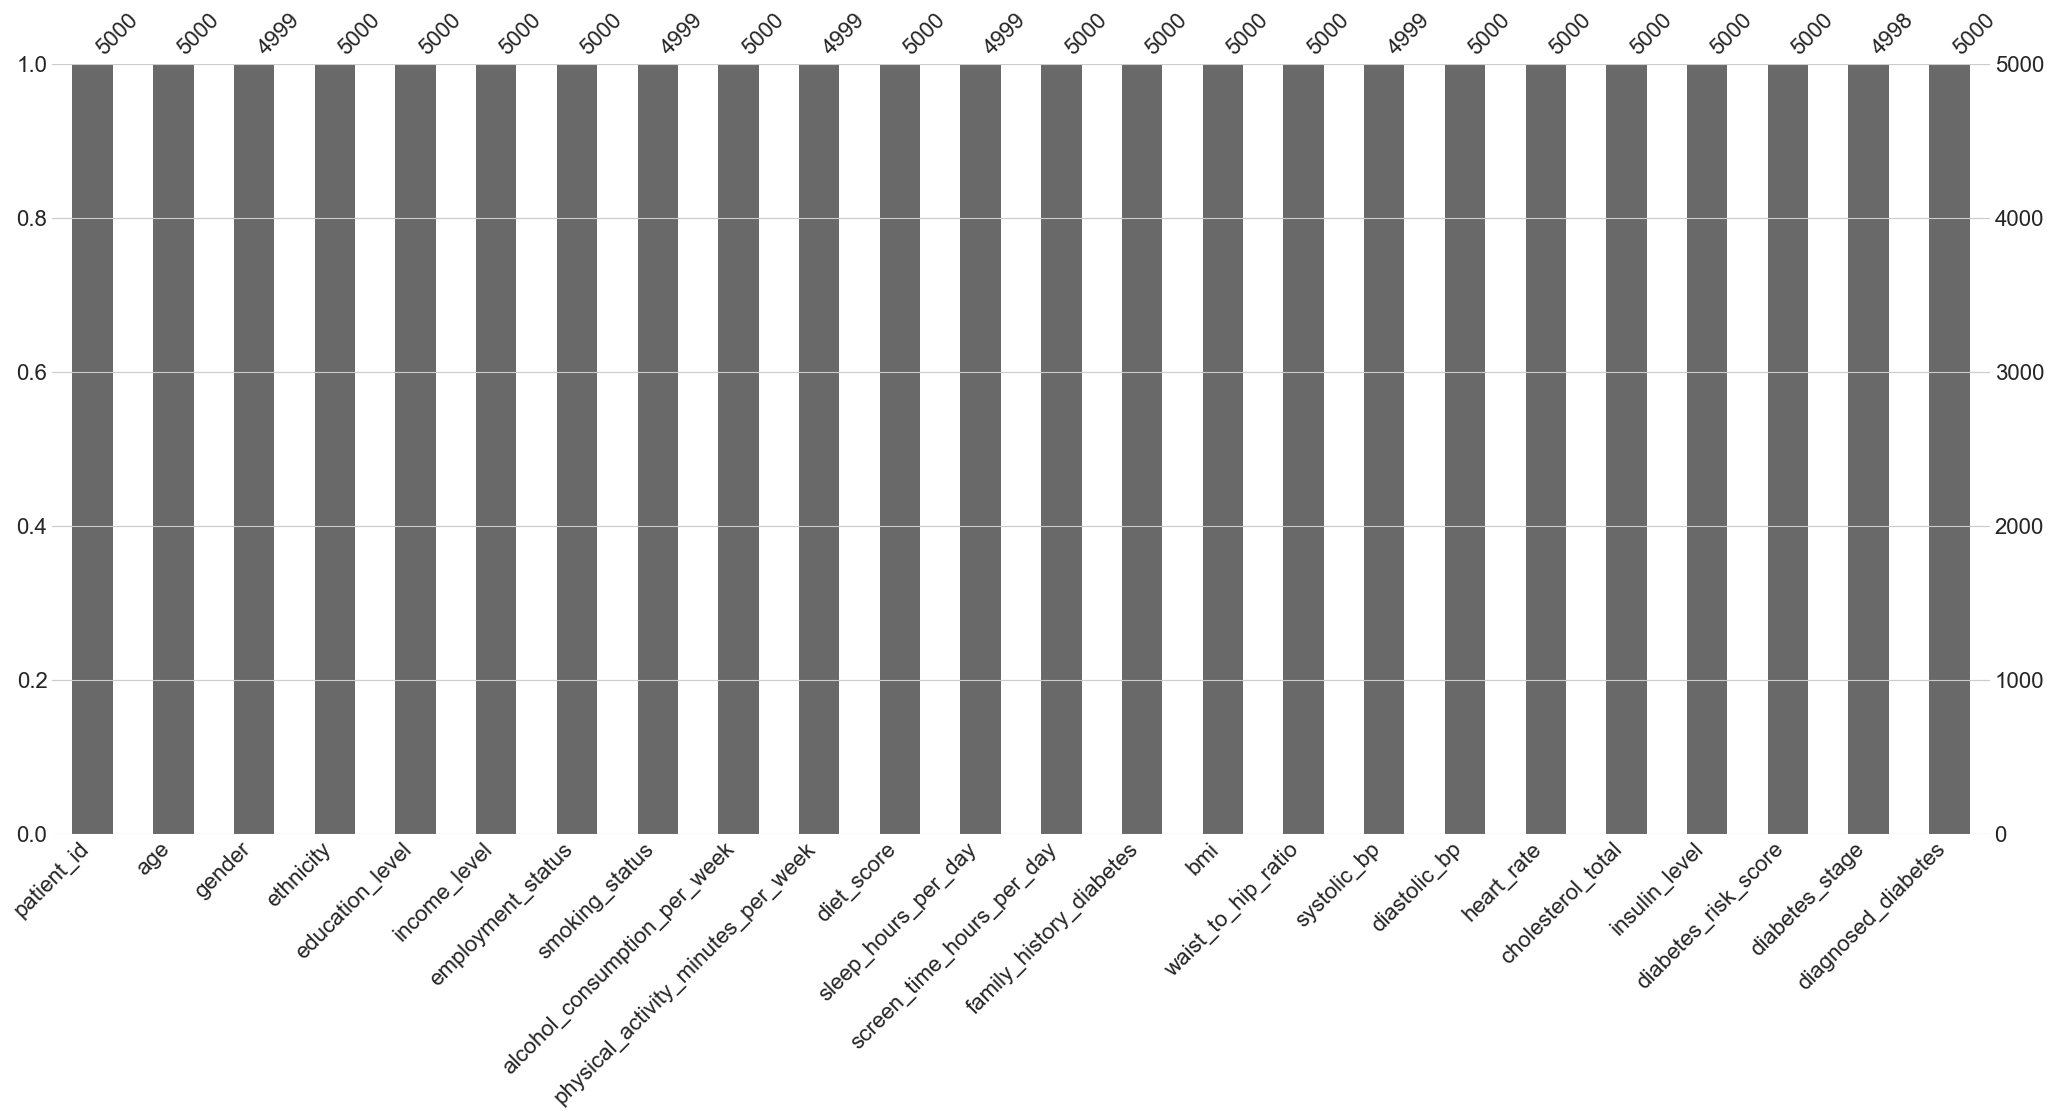

In [499]:
msno.bar(raw_train)

In [500]:
initial_missing = sum(raw_train.isna().sum())

In [501]:
raw_train[raw_train.duplicated()]

,patient_id,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,...,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,insulin_level,diabetes_risk_score,diabetes_stage,diagnosed_diabetes


No duplicates found

## Replacing typos

In [502]:
def replace_mistakes(df, column_name, old, new):
    """Function to replace mistakes in categorical values"""
    mask = df[column_name] == old
    df.loc[mask, column_name] = new

In [503]:
for i in categorical_features:
    print(raw_train[i].value_counts(), end="\n\n")

gender
Female    2496
Male      2390
Other      113
Name: count, dtype: int64

ethnicity
White       2223
Hispanic    1008
Black        898
Asian        608
Other        263
Name: count, dtype: int64

education_level
Highschool      2248
Graduate        1745
Postgraduate     784
No formal        222
University         1
Name: count, dtype: int64

income_level
Middle          1758
Lower-Middle    1272
Upper-Middle     966
Low              756
High             248
Name: count, dtype: int64

employment_status
Employed      2975
Retired       1134
Unemployed     577
Student        314
Name: count, dtype: int64

smoking_status
Never      2944
Current    1051
Former     1003
Mever         1
Name: count, dtype: int64

diabetes_stage
Type 2          3031
Pre-Diabetes    1524
No Diabetes      419
Gestational       17
Type 1             5
Type 22            1
Type3              1
Name: count, dtype: int64



Fix mistakes

In [504]:
number_of_fixed = 0

In [505]:
replace_mistakes(raw_train, "smoking_status", "Mever", "Never")
number_of_fixed += 1
raw_train['smoking_status'].value_counts()

smoking_status
Never      2945
Current    1051
Former     1003
Name: count, dtype: int64

In [506]:
replace_mistakes(raw_train, "diabetes_stage", "Type 22", "Type 2")
replace_mistakes(raw_train, "diabetes_stage", "Type3", "Type 2")
number_of_fixed += 2
raw_train['diabetes_stage'].value_counts()

diabetes_stage
Type 2          3033
Pre-Diabetes    1524
No Diabetes      419
Gestational       17
Type 1             5
Name: count, dtype: int64

In [507]:
replace_mistakes(raw_train, "education_level", "University", "Graduate")
number_of_fixed += 1
raw_train['education_level'].value_counts()

education_level
Highschool      2248
Graduate        1746
Postgraduate     784
No formal        222
Name: count, dtype: int64

In [508]:
replace_mistakes(raw_train, "family_history_diabetes", 2, 1)
replace_mistakes(raw_train, "diagnosed_diabetes", 2, 1)
number_of_fixed += 2

In [509]:
print("number of typo fixed:", number_of_fixed)

number of typo fixed: 6


## Graphical analysis

In [510]:
def get_numeric(df):
    """Function to find and return the names of quantitative features in the dataset"""
    return df.select_dtypes(include=['float64', 'int64']).columns

def draw_categorical(df):
    """Function to draw graphs for all categorical and quantitative discrete (4 or less levels)
    factors in the table data.csv. If the categorical factor has more than 4 unique values,
    a bar chart is drawn, if less - a pie chart."""
    columns = [column for column in df.columns if column not in get_numeric(df) or
               len(df[column].unique()) <= 4]
    f, ax = plt.subplots(3, 3, figsize=(18, 18))
    for i in range(len(columns)):
        x, y = i // 3, i % 3
        if len(df[columns[i]].unique()) <= 4:
            df[columns[i]].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[x, y])
            ax[x, y].set_ylabel('Proportion of values')
        else:
            df[columns[i]].value_counts().plot(kind='bar', ax=ax[x, y])
            ax[x, y].set_ylabel('values')
        ax[x, y].set_xlabel(columns[i], fontsize=15)
        ax[x, y].set_title(f'Graph of the distribution of the factor\n{columns[i]}')
    plt.tight_layout()
    plt.show()

def draw_numerical(df):
    """Function to draw graphs for quantitative factors in the table
    data.csv. Draws boxplots and histograms with density distribution"""
    columns = [column for column in get_numeric(df) if len(df[column].unique()) > 4]
    f, ax = plt.subplots(8, 4, figsize=(30, 70))
    for i in range(len(columns)):
        x, y = i // 2, i % 2
        sns.histplot(data=df, x=columns[i], kde=True, ax=ax[x, 2 * y], color='skyblue', edgecolor='black')
        sns.boxplot(data=df, x=columns[i], ax=ax[x, 2 * y + 1], color='lightgreen')
        ax[x, 2 * y].set_ylabel('Distribution of values')
        ax[x, 2 * y + 1].set_ylabel('Distribution of values')
        ax[x, 2 * y].set_xlabel(columns[i], fontsize=15)
        ax[x, 2 * y + 1].set_xlabel(columns[i], fontsize=15)
        ax[x, 2 * y].set_title(f'Graph of the density distribution of the factor\n{columns[i]}')
        ax[x, 2 * y + 1].set_title(f'Boxplot of the distribution of the factor\n{columns[i]}')
    plt.tight_layout()
    plt.show()

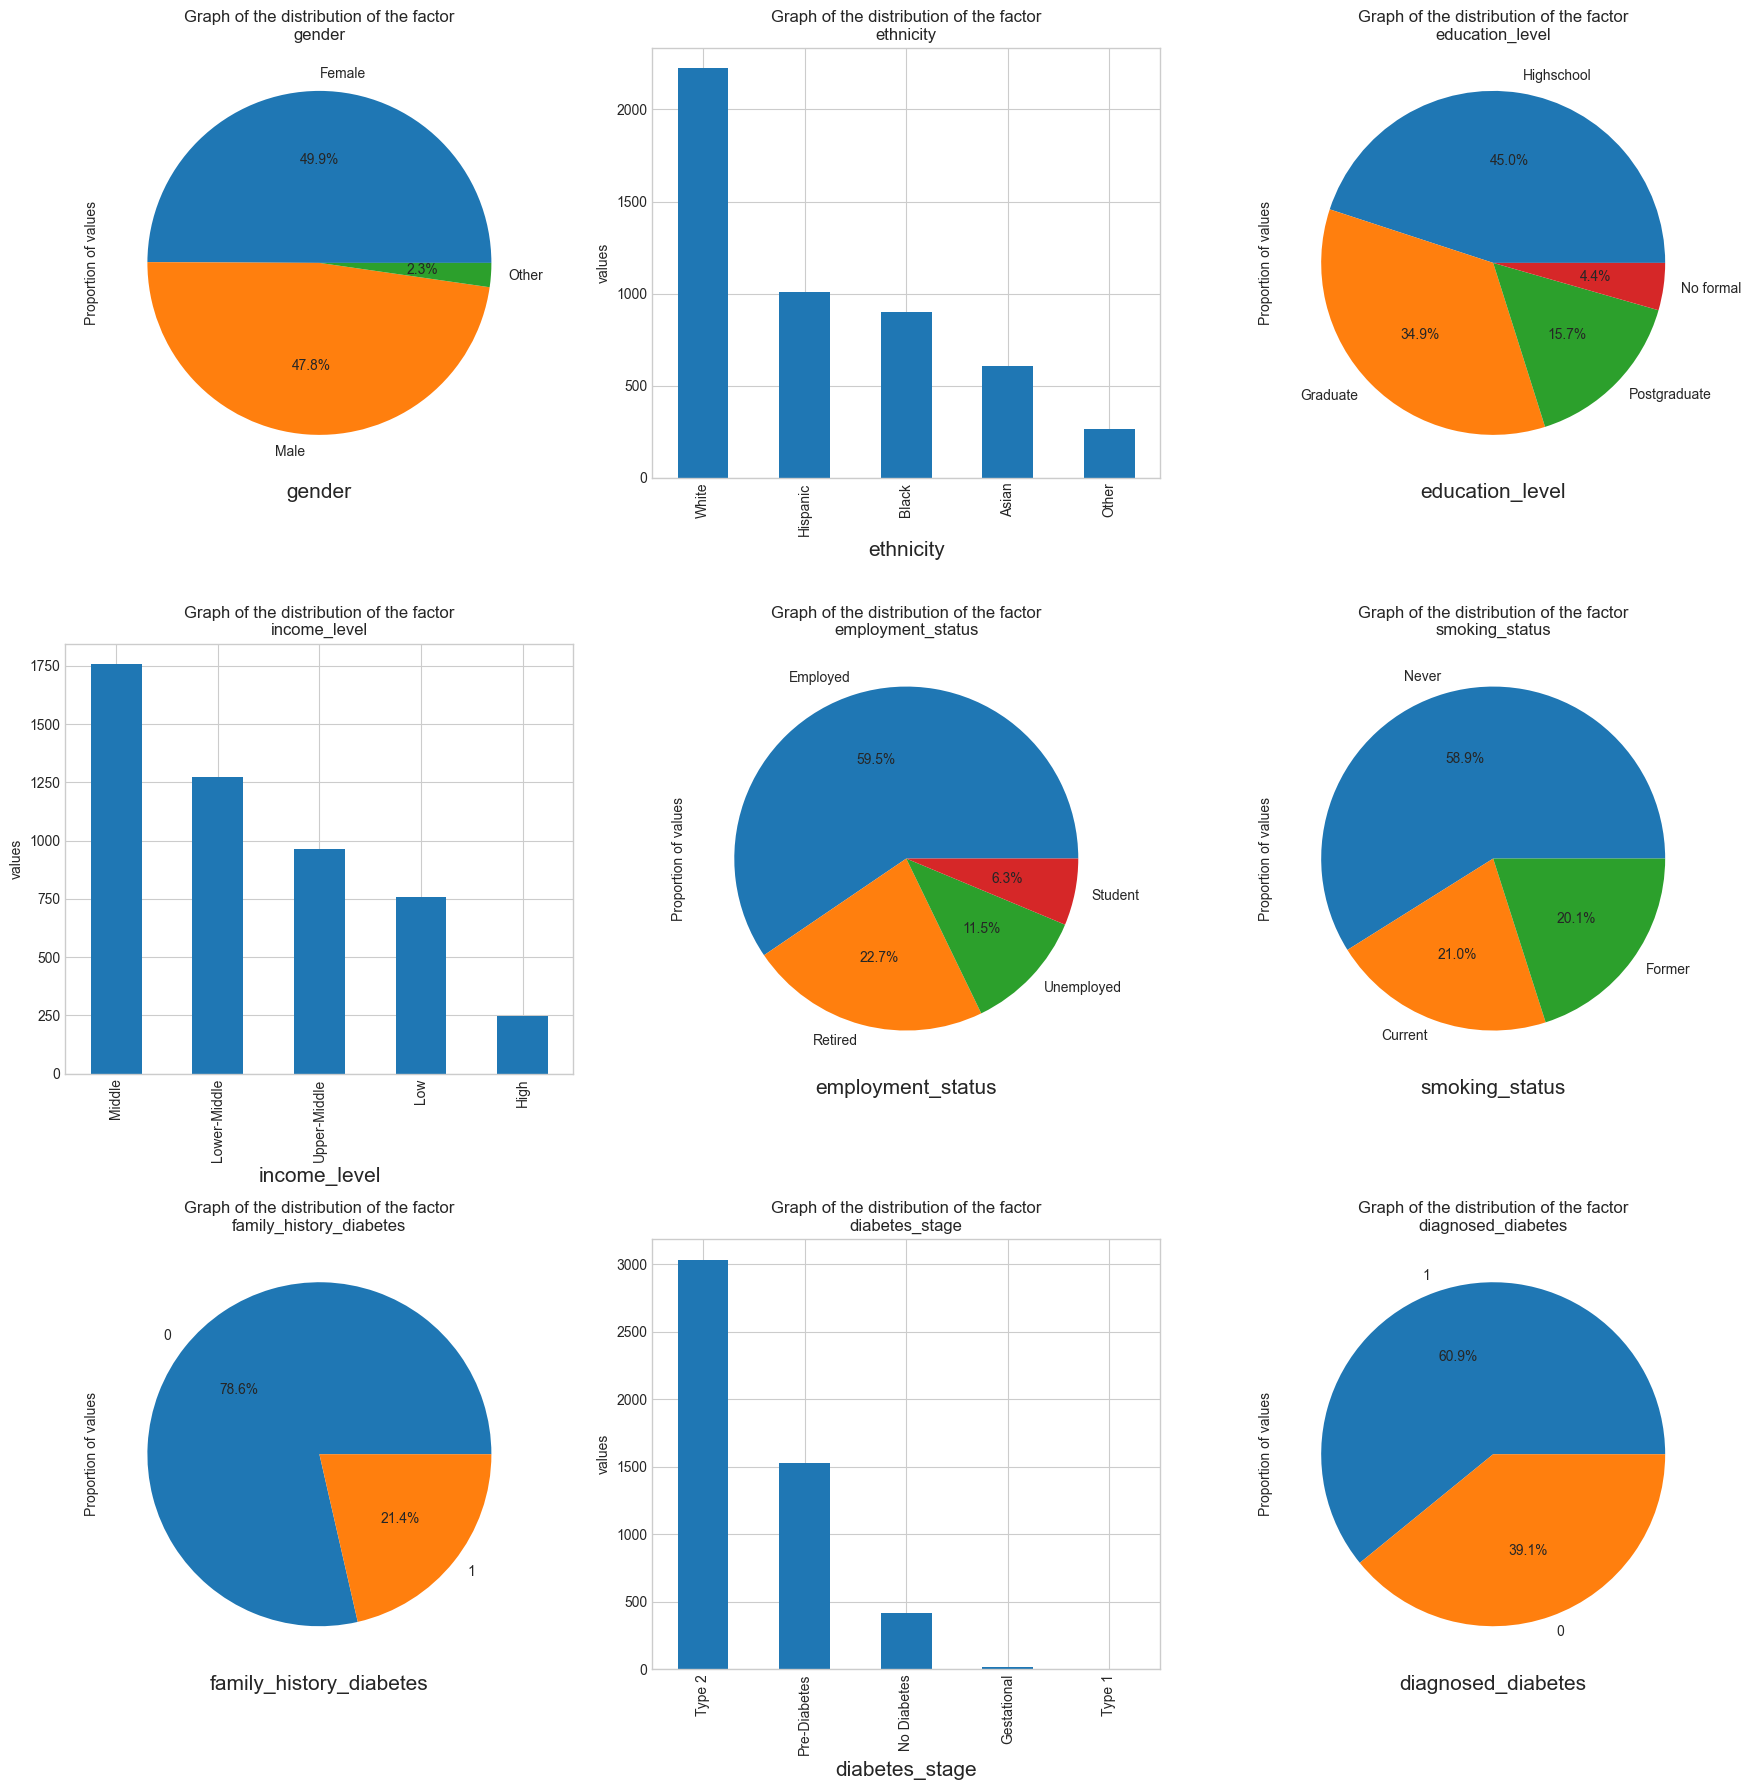

In [511]:
draw_categorical(raw_train)

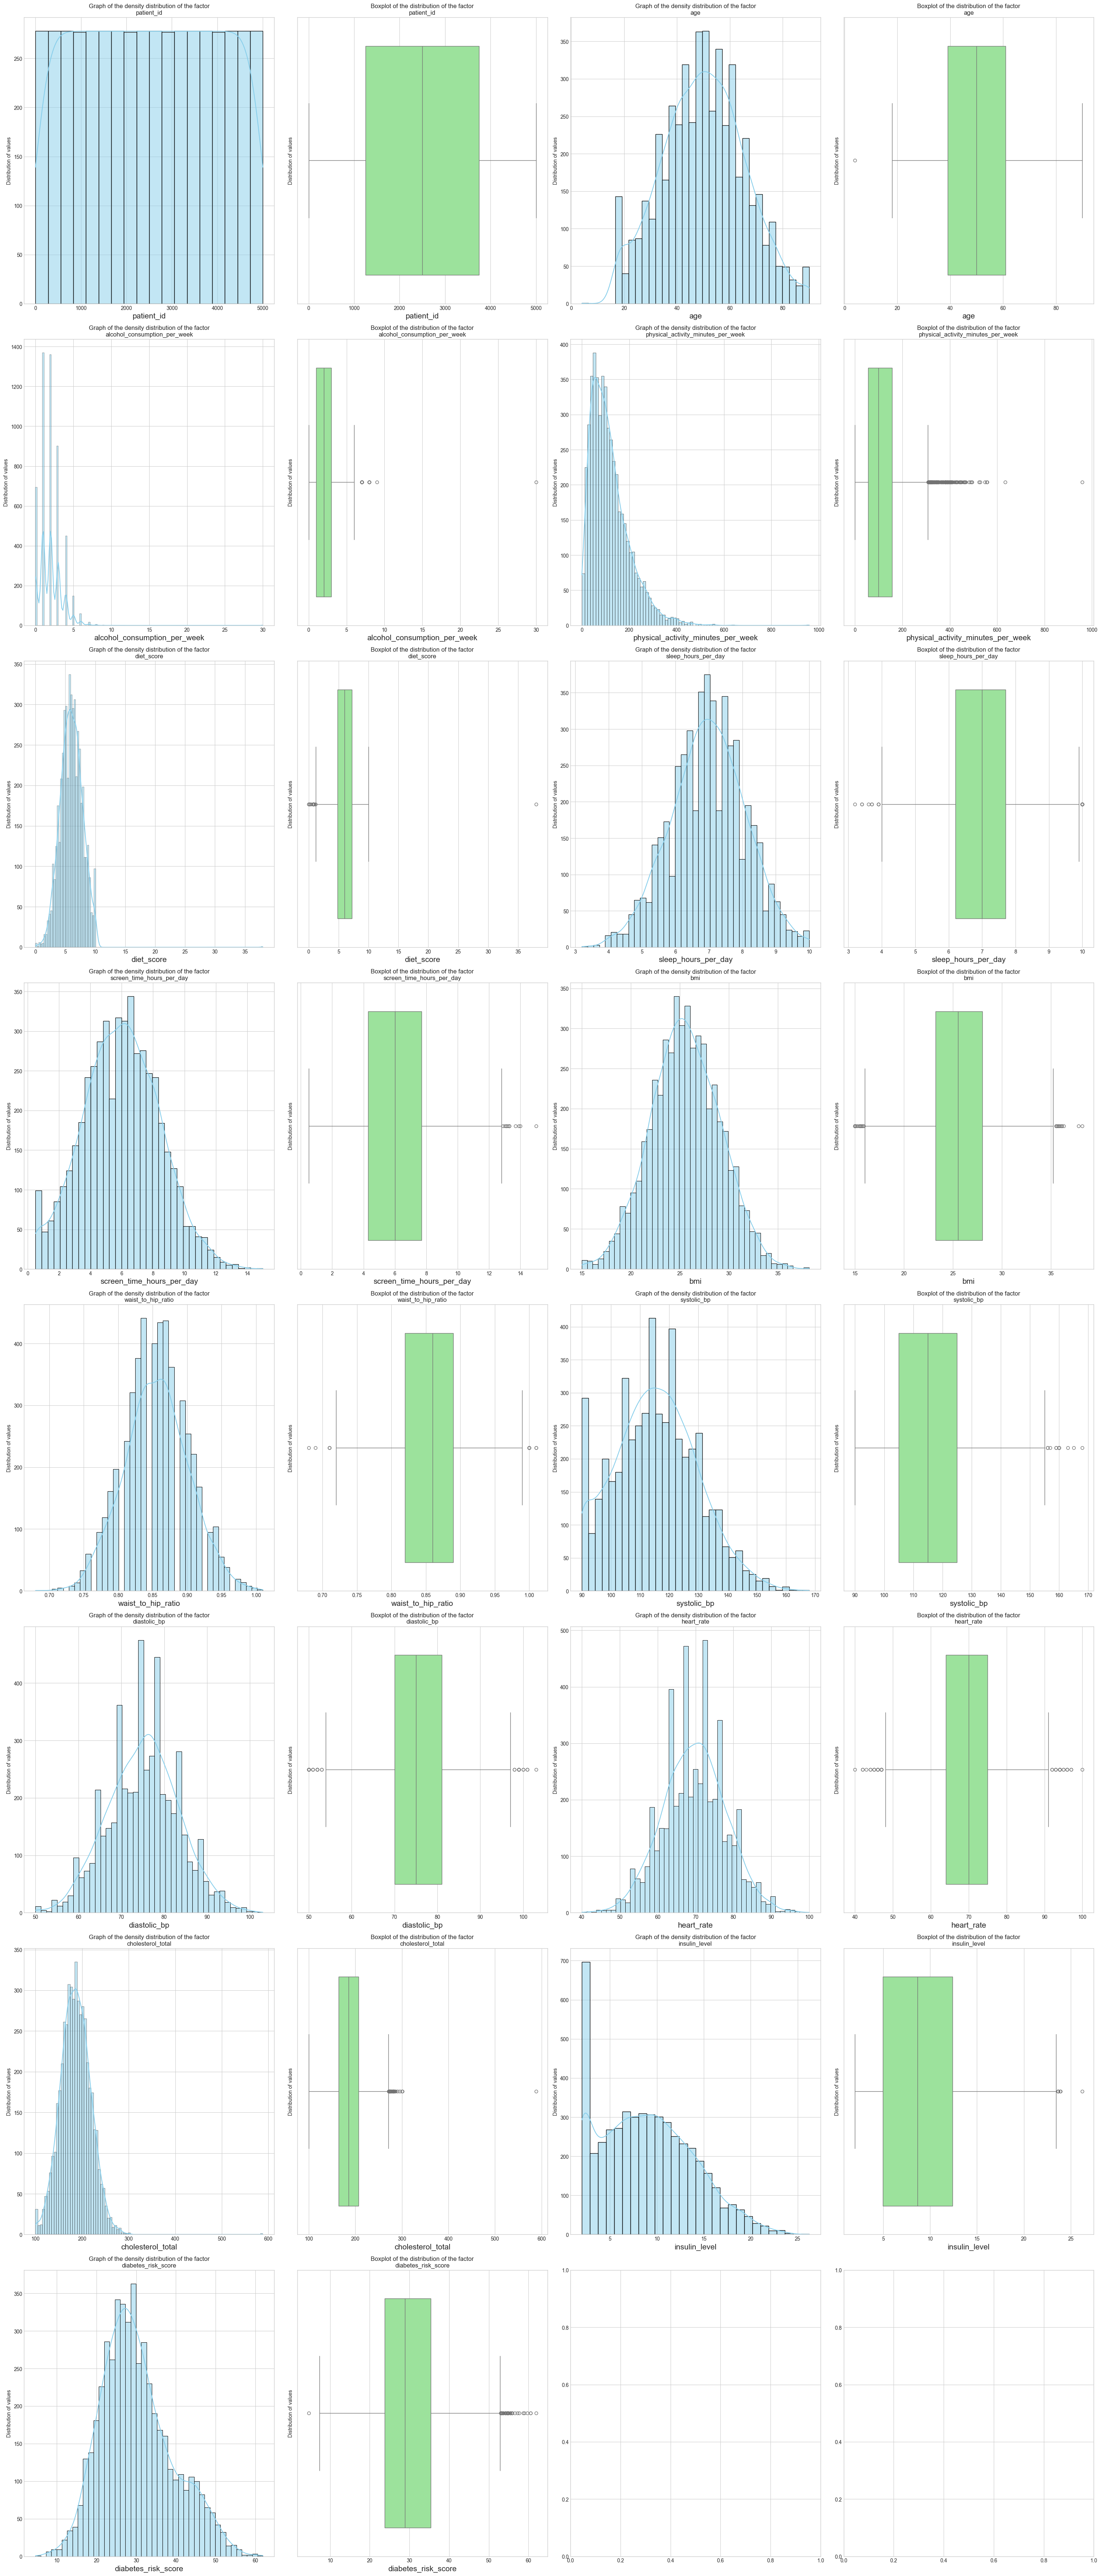

In [512]:
draw_numerical(raw_train)

alcohol_consumption_per_week, physical_activity_minutes_per_week, diet_score, cholesterol_total, have extreme values, will be looked through more.
No obvious lower bound ejections in plots.

## Ejections

In [513]:
def median_by_group(df, group_name, column_name):
    """Function to find the median by groups,
    returns a dictionary of group name: median of this group"""
    ans = {}
    if group_name == '':
        ans = df[column_name].median()
    else:
        for name in df[group_name].unique():
            ans[name] = df.loc[df[group_name] == name, column_name].median()
    return ans

def mode_by_group(df, group_name, column_name):
    """Function to find the mode by groups,
    returns a dictionary of group name: mode of this group"""
    ans = {}
    if group_name == '':
        ans = df[column_name].mode()
    else:
        for name in df[group_name].unique():
            mode_series = df.loc[df[group_name] == name, column_name].mode()
            ans[name] = mode_series.iloc[0] if not mode_series.empty else None
    return ans

def ejection(df, column_name):
    """Function to return the upper and lower bounds for using the method of determining
    outliers using 2.5 interquartile ranges"""
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    return {'lower': q1 - iqr * 2.5, 'upper': q3 + iqr * 2.5}


def replace_ejection_with_medians(df, group_name, column_name):
    """Function to replace outliers with the median by groups"""
    lower = ejection(df, column_name).get('lower')
    upper = ejection(df, column_name).get('upper')
    medians = median_by_group(df, group_name, column_name)
    if group_name == '':
        mask = (df[column_name] < lower) | (df[column_name] > upper)
        df.loc[mask, column_name] = medians
    else:
        for group_value in df[group_name].unique():
            mask = ((df[column_name] < lower) | (df[column_name] > upper)) & (df[group_name] == group_value)
            df.loc[mask, column_name] = medians[group_value]

In [514]:
number_of_replaced = 0

In [515]:
raw_train.loc[raw_train['alcohol_consumption_per_week'] > ejection(raw_train, 'alcohol_consumption_per_week').get('upper'), 'alcohol_consumption_per_week']

103      9
3507    30
Name: alcohol_consumption_per_week, dtype: int64

we can see that there is an extreme value at idx 3507 with value 30, which is an obvious ejection. So we should replace the ejections by the median

In [516]:
raw_train.loc[raw_train['physical_activity_minutes_per_week'] > ejection(raw_train, 'physical_activity_minutes_per_week').get('upper'), 'physical_activity_minutes_per_week']

139     425.0
175     960.0
217     412.0
393     493.0
678     529.0
924     439.0
1033    422.0
1078    448.0
1783    557.0
1891    634.0
1934    467.0
2184    413.0
2195    446.0
2203    427.0
2246    524.0
2474    549.0
2669    494.0
2970    459.0
3029    442.0
3091    450.0
3158    488.0
3502    445.0
3775    462.0
3842    429.0
4447    482.0
4450    463.0
4533    464.0
4579    430.0
4665    432.0
4673    420.0
4716    410.0
4976    558.0
Name: physical_activity_minutes_per_week, dtype: float64

There are a lot of ejections in terms of 2.5 interquartile ranges, so we should not replace them with the median. Naturally, some people tend to do sports very often and 600 minutes per week is not as big of a value (10h/week)

In [517]:
raw_train['diet_score'].describe()

count    5000.000000
mean        5.997120
std         1.854113
min         0.000000
25%         4.800000
50%         6.000000
75%         7.200000
max        38.000000
Name: diet_score, dtype: float64

In [518]:
raw_train.loc[raw_train['diet_score'] > ejection(raw_train, 'diet_score').get('upper'), 'diet_score']

2022    38.0
Name: diet_score, dtype: float64

Obvious ejection of 38 when mean is 6, std is 2

In [519]:
raw_train['cholesterol_total'].describe()

count    5000.000000
mean      186.047000
std        32.316566
min       100.000000
25%       164.000000
50%       186.000000
75%       207.000000
max       588.000000
Name: cholesterol_total, dtype: float64

In [520]:
raw_train.loc[raw_train['cholesterol_total'] > ejection(raw_train, 'cholesterol_total').get('upper'), 'cholesterol_total']

1346    588
Name: cholesterol_total, dtype: int64

one more obvious ejection of 588 when mean is 186, std is 32

In [521]:
number_of_replaced += len(raw_train.loc[raw_train['alcohol_consumption_per_week'] > ejection(raw_train, 'alcohol_consumption_per_week').get('upper')])
replace_ejection_with_medians(raw_train, 'diagnosed_diabetes', 'alcohol_consumption_per_week')
number_of_replaced += len(raw_train.loc[raw_train['diet_score'] > ejection(raw_train, 'diet_score').get('upper')])
replace_ejection_with_medians(raw_train, 'diagnosed_diabetes', 'diet_score')
number_of_replaced += len(raw_train.loc[raw_train['cholesterol_total'] > ejection(raw_train, 'cholesterol_total').get('upper')])
replace_ejection_with_medians(raw_train, 'diagnosed_diabetes', 'cholesterol_total')

I've replaced ejections with medians by the group of diagnosed_diabetes.

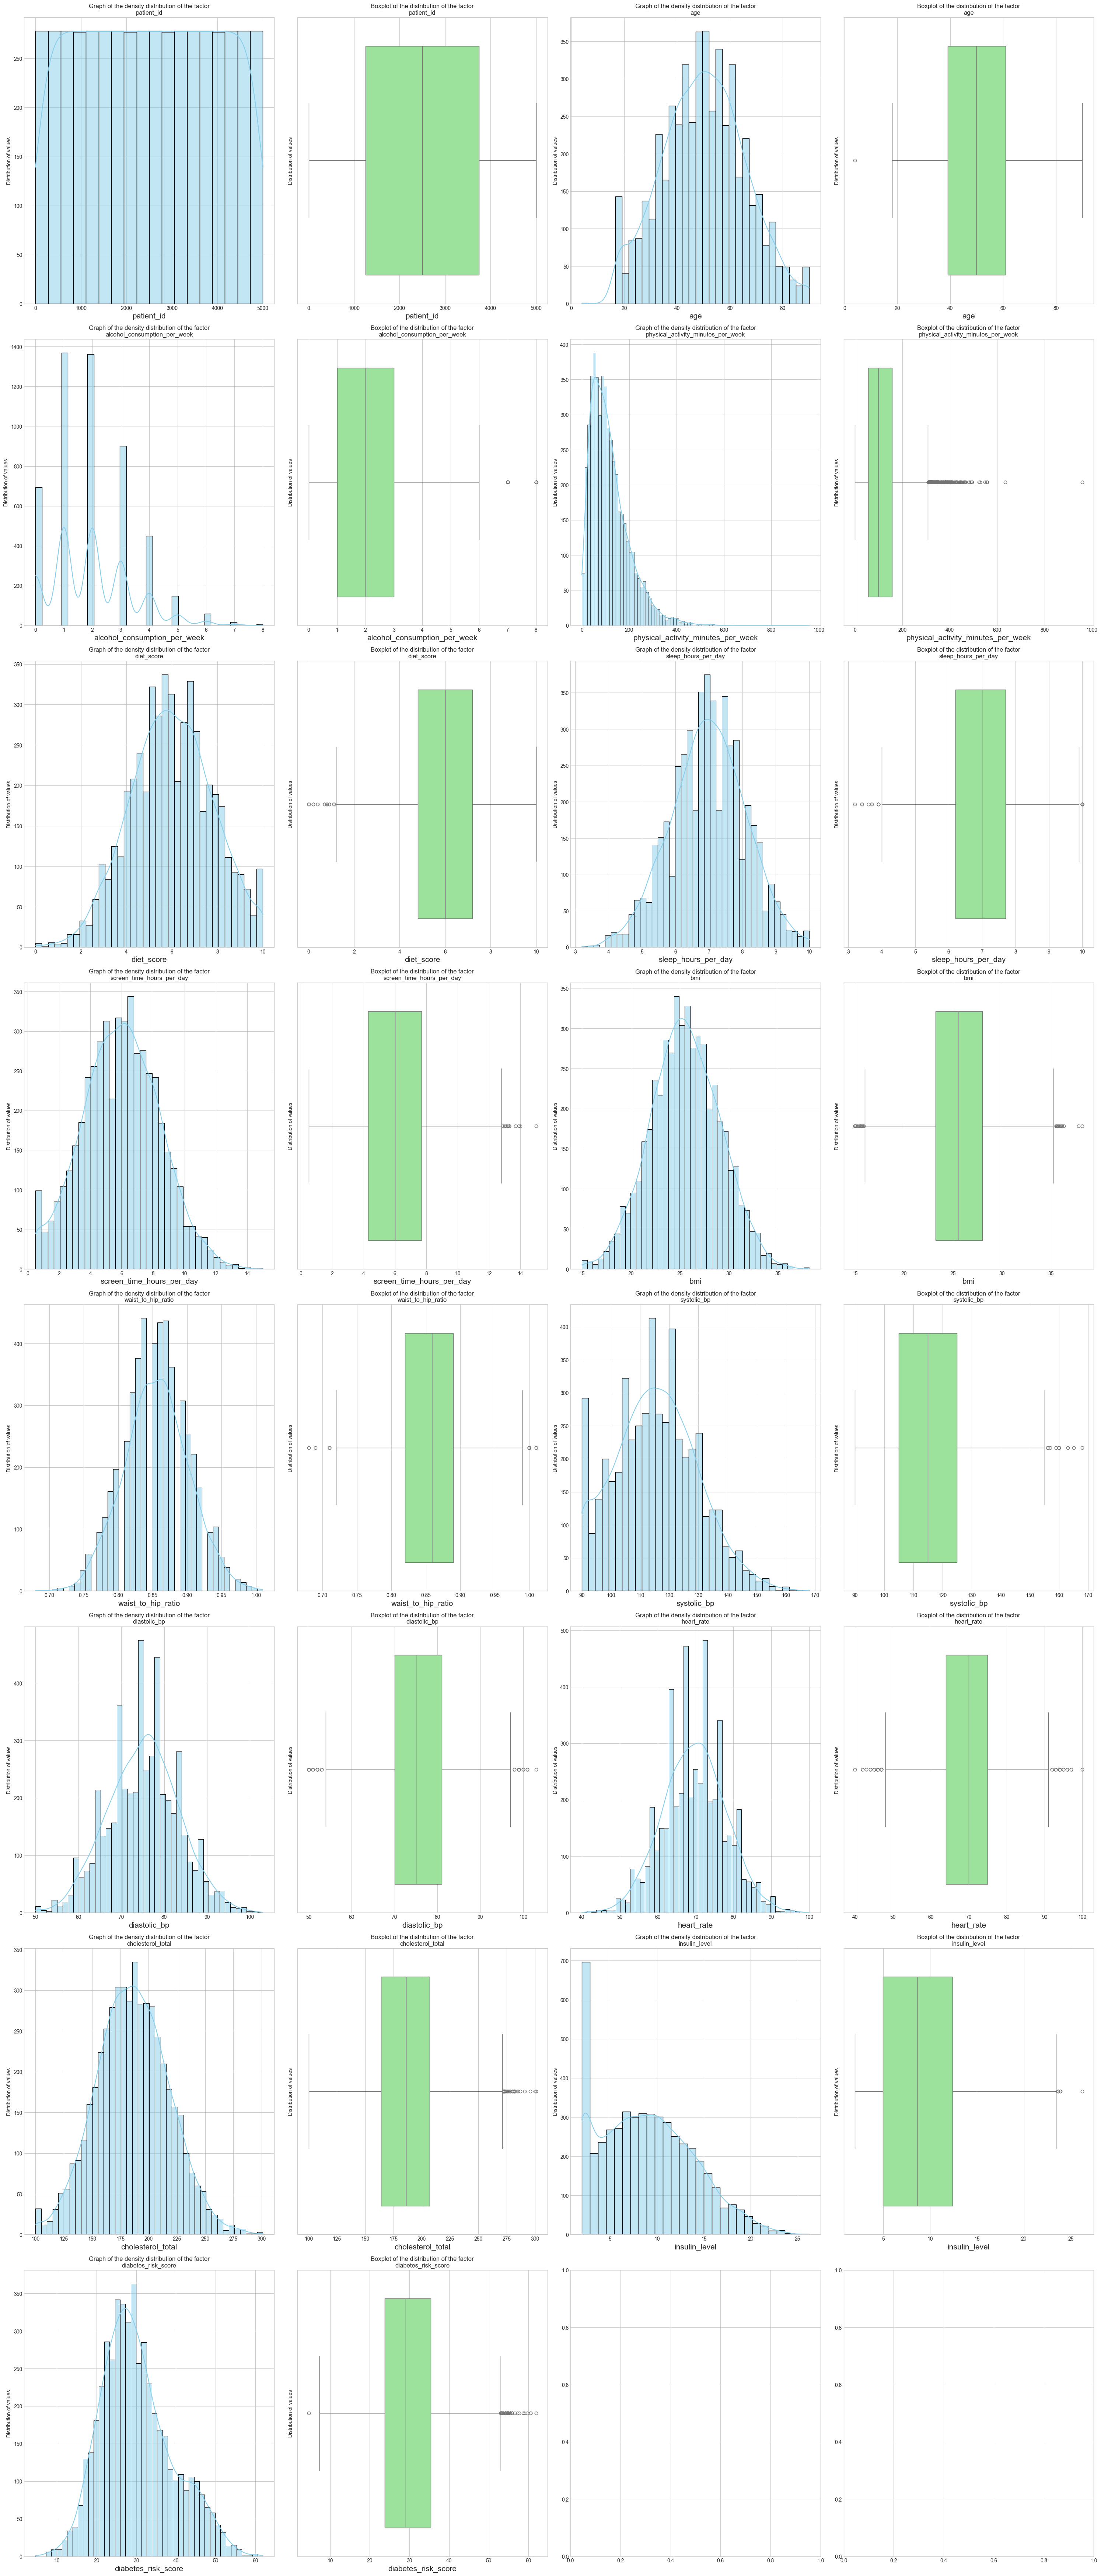

In [522]:
draw_numerical(raw_train)

now we can see that all the distributions are normal and look almost the same

In [523]:
print("number of ejection replaced by median by the group of diagnosed_diabetes:", number_of_replaced)

number of ejection replaced by median by the group of diagnosed_diabetes: 4


## Empty values

In [524]:
number_of_filled = 1 # we filled family history diabetes in the beginning

In [525]:
raw_train.isna().sum()

patient_id                            0
age                                   0
gender                                1
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        1
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    1
diet_score                            0
sleep_hours_per_day                   1
screen_time_hours_per_day             0
family_history_diabetes               0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           1
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
insulin_level                         0
diabetes_risk_score                   0
diabetes_stage                        2
diagnosed_diabetes                    0
dtype: int64

In [526]:
number_of_filled += raw_train['gender'].isna().sum()
raw_train['gender'].fillna('Other', inplace=True)
raw_train['gender'].isna().sum()

np.int64(0)

In [527]:
number_of_filled += raw_train['smoking_status'].isna().sum()
raw_train['smoking_status'].fillna(raw_train['smoking_status'].mode().iloc[0], inplace=True)
raw_train['smoking_status'].isna().sum()

np.int64(0)

In [528]:
raw_train[raw_train['diabetes_stage'].isna()]

,patient_id,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,...,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,insulin_level,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
368,369,38,Male,White,Highschool,Middle,Employed,Former,1,30.0,...,29.8,0.87,108.0,73,87,194,10.45,29.7,NaN,0
4604,4605,77,Female,Hispanic,Graduate,Upper-Middle,Employed,Current,0,109.0,...,27.4,0.90,142.0,74,67,185,10.96,51.9,NaN,1


In [529]:
raw_train['diabetes_risk_score'].describe()

count    5000.00000
mean       30.14502
std         8.97891
min         4.60000
25%        23.80000
50%        28.90000
75%        35.40000
max        61.90000
Name: diabetes_risk_score, dtype: float64

Since the patient with patient_id 369 has a diabetes_risk very close to mean and diagnosed_diabetes = 0. Then we should fill the diabetes stage with either no diabetes, pre-diabetes or gestational. It cannot be gestational, because gestational is during pregnancy and our patient is male. It cannot be no diabetes because the diabetes risk score is high enough and we should fill it with pre-diabetes.

The patient with patient_id 4605 has diabetes and let's fill it with Type 2 because it's the most frequent type and has the highest likelihood.

In [530]:
number_of_filled += raw_train['diabetes_stage'].isna().sum()
raw_train['diabetes_stage'][raw_train['patient_id'] == 369] = raw_train['diabetes_stage'][raw_train['patient_id'] == 369].fillna('Pre-Diabetes')
raw_train['diabetes_stage'][raw_train['patient_id'] == 4605] = raw_train['diabetes_stage'][raw_train['patient_id'] == 4605].fillna('Type 2')
raw_train['diabetes_stage'].isna().sum()

np.int64(0)

In [531]:
for column in ['physical_activity_minutes_per_week', 'sleep_hours_per_day', 'systolic_bp']:
    number_of_filled += raw_train[column].isna().sum()
    raw_train[column].fillna(raw_train[column].median(), inplace=True)
    print(raw_train[column].isna().sum())

0
0
0


In [532]:
raw_train.isna().sum()

patient_id                            0
age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
insulin_level                         0
diabetes_risk_score                   0
diabetes_stage                        0
diagnosed_diabetes                    0
dtype: int64

In [533]:
print("number of filled empty values:", number_of_filled)

number of filled empty values: 8


## Correlational analysis

In [534]:
def all_correlations(df):
    """
    Function for finding correlations between all pairs of factors of the following types: 1. quantitative-quantitative and 2. categorical-categorical;
    We use the spearmanr function for the first type of pairs, since in our calculations and research we have determined that all quantitative factors are distributed abnormally;
    We use the chi2_contingency function to find chi-square, then use Cramer's V coefficient to find the correlation.
    Returns a dictionary (factor1, factor2): (correlation, p_value, correlation type). The correlation is rounded to 2 decimal places, and p_value is rounded to 4 decimal places.
    """
    ans = {}
    columns = df.columns
    numeric = get_numeric(df)
    pairs = []
    for i in range(len(columns) - 1):
        for j in range(i + 1, len(columns)):
            pairs.append((columns[i], columns[j]))

    for pair in pairs:
        correlation_type=''
        first, second = pair[0], pair[1]
        statistic, p_value = 0, 1
        # if both factors are quantitative
        if first in numeric and second in numeric:
            correlation_type = 'numeric'
            statistic, p_value = spearmanr(df[first], df[second])
        # if both factors are categorical
        elif first not in numeric and second not in numeric:
            correlation_type='categorical'
            contingency_table = pd.crosstab(df[first], df[second]).fillna(0)
            if not contingency_table.empty:
                chi_2, p_value, _, _ = chi2_contingency(contingency_table)
                statistic = cramer_correlation(chi_2, df, contingency_table)

        ans[pair] = (round(statistic, 2), round(p_value, 4), correlation_type)
    return dict(sorted(ans.items(), key=lambda x: abs(x[1][0]), reverse=True)) # sort by correlation


def cramer_correlation(chi_2, df, contingency_table):
    """
    Function for finding the Cramer's V coefficient
    If the contingency table has a size of k x 1 or 1 x k, we return 0 to avoid division by zero
    """
    return round(math.sqrt(chi_2 / (len(df) * (min(contingency_table.shape) - 1))), 4) if min(contingency_table.shape) - 1 != 0 else 0


def data_correlations(d):
    """This function creates a new dataset from the dictionary and returns the first 20 rows of the dataset"""
    data = {'factor_1': [], 'factor_2': [], 'correlation': [], 'p_value': [], 'correlation_type': [],}
    for key, value in d.items():
        data['factor_1'].append(key[0])
        data['factor_2'].append(key[1])
        data['correlation'].append(value[0])
        data['p_value'].append(value[1])
        data['correlation_type'].append(value[2])

    data = pd.DataFrame(data)
    data.dropna(inplace=True)

    return data.head(20)





In [535]:
dict_of_corrs = all_correlations(raw_train)
correlation_df = data_correlations(dict_of_corrs)
correlation_df

,factor_1,factor_2,correlation,p_value,correlation_type
0,diabetes_stage,diagnosed_diabetes,1.00,0.0,categorical
1,bmi,waist_to_hip_ratio,0.74,0.0,numeric
2,age,systolic_bp,0.53,0.0,numeric
3,age,diabetes_risk_score,0.52,0.0,numeric
4,bmi,insulin_level,0.37,0.0,numeric
5,physical_activity_minutes_per_week,diabetes_risk_score,-0.35,0.0,numeric
6,systolic_bp,diabetes_risk_score,0.35,0.0,numeric
7,bmi,diabetes_risk_score,0.32,0.0,numeric
8,waist_to_hip_ratio,insulin_level,0.30,0.0,numeric
9,age,cholesterol_total,0.28,0.0,numeric


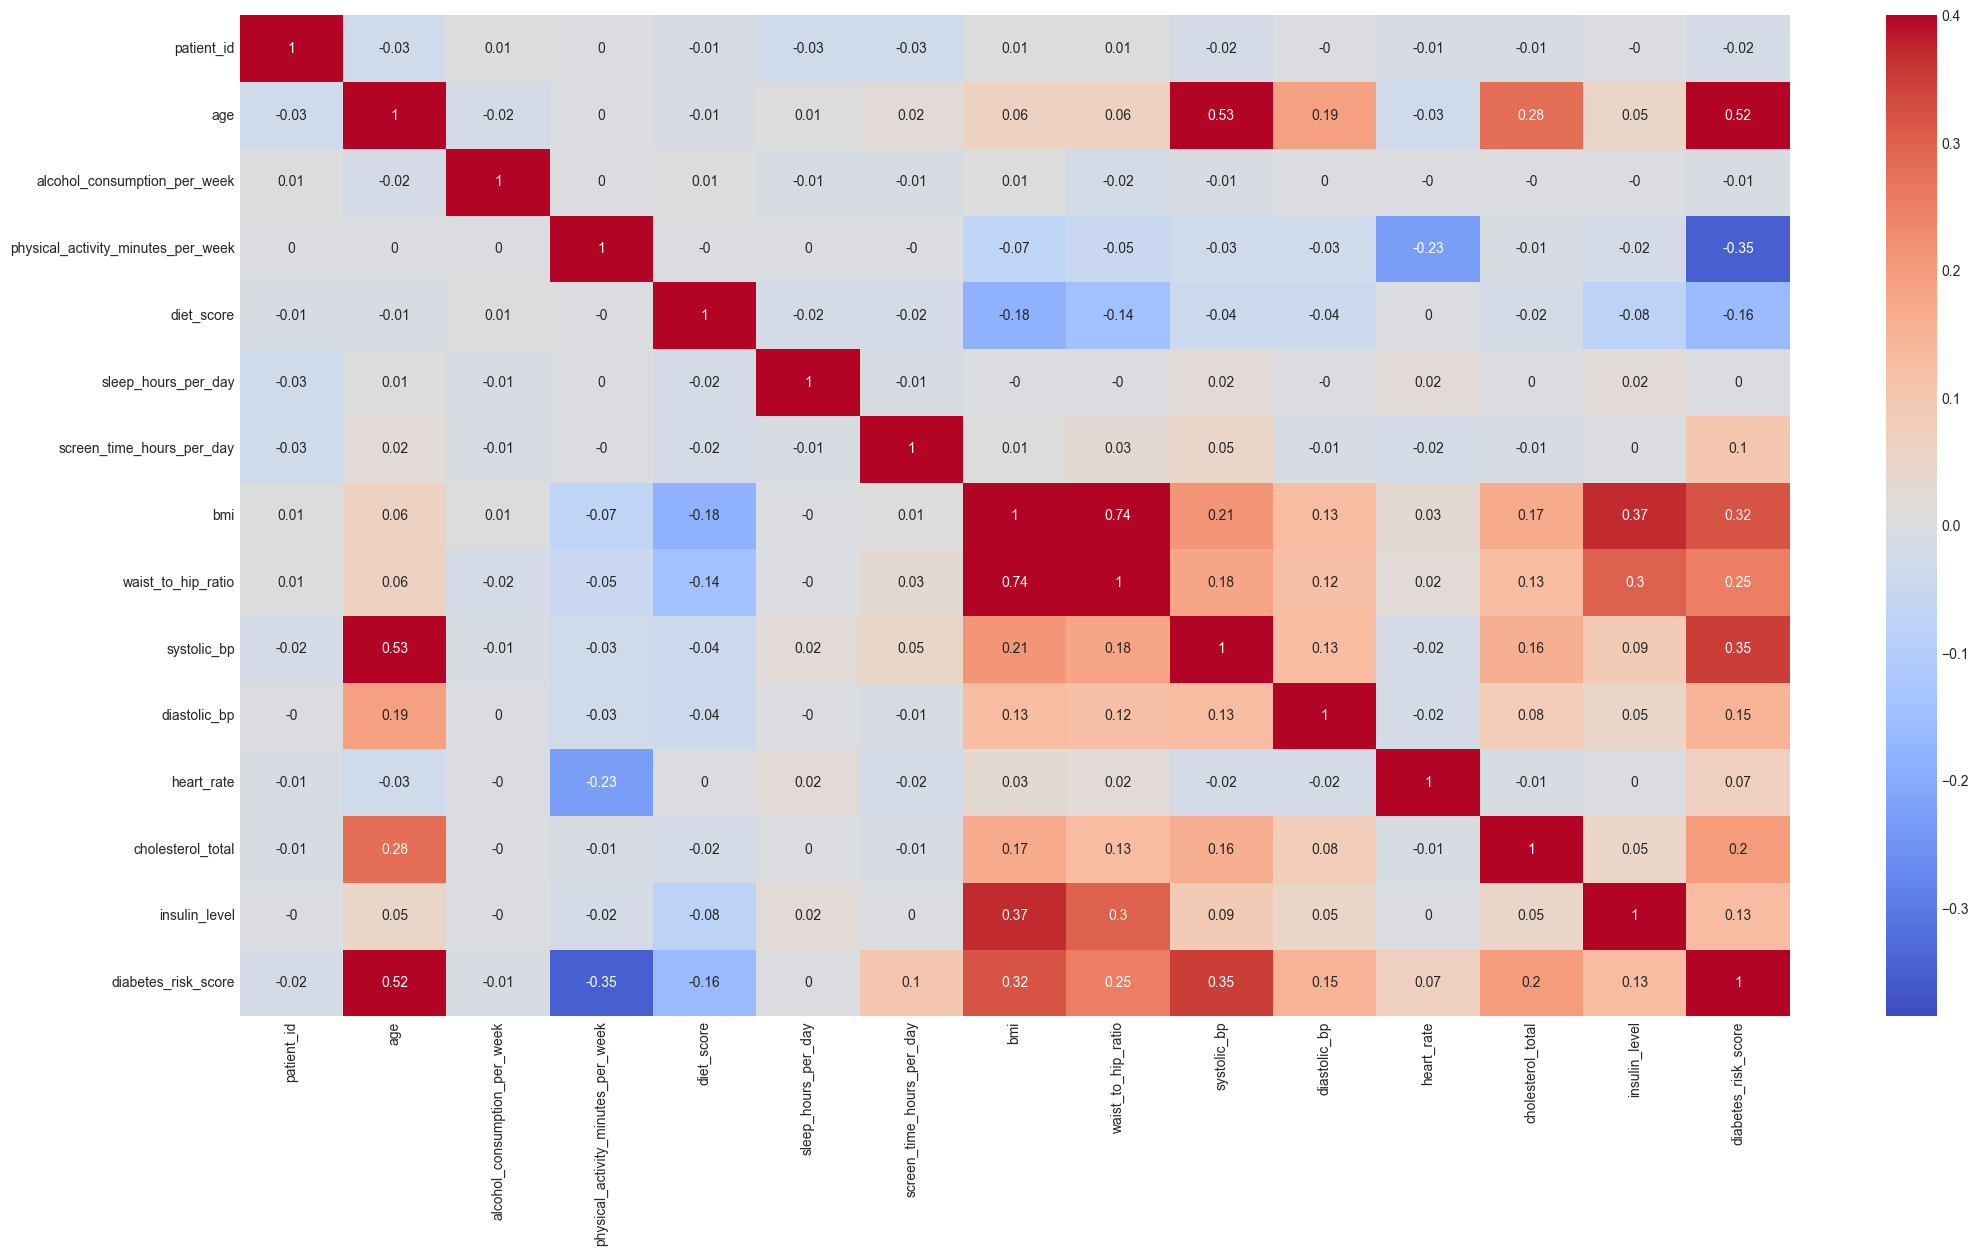

In [536]:
plt.figure(figsize=(25, 13))
sns.heatmap(data=round(raw_train[get_numeric(raw_train)].corr(method='spearman'), 2), annot=True, cmap='coolwarm', vmin=0.4, vmax=-0.35)
plt.show()

p_values for all the correlations rounded to 4 decimal points are 0.0. It means that all the correlations are significant.

1. If we look at the feature age, it is pretty obvious that systolic_bp, cholesterol are positively correlated with age. But it is interesting that there's a moderate correlation of 0.52 between age and diabetes_risk_score. It means that as a patient gets older, they have a higher risk of getting diabetes.
2. If we take a look at the physical_activity_minutes_per_week, there's a moderate negative correlation of -0.35 between diabetes risk score. It means that if a patient is more active, they have a lower risk of getting diabetes. The same with heart rate. The higher the activity, the less is the heart rate. Higher heart rate naturally means that the organism is under stress.
3. BMI also has a moderate correlation of 0.32 with diabetes risk score which is also interesting. It means that the more obese a patient is, the higher their chance of diabetes is. Cholesterol, systolic blood pressure, waist to hip ratio (obesity) also have some positive correlation that support my statement.

## Modelling

In [537]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [538]:
train = raw_train.copy()
test = raw_test.copy()

In [539]:
# Define feature set (remove targets + ID-like columns)
TARGET_BIN = "diagnosed_diabetes"
TARGET_MULTI = "diabetes_stage"
TARGET_REG = "diabetes_risk_score"

target_cols = [TARGET_BIN, TARGET_MULTI, TARGET_REG]

# ID columns that should NOT be used as predictors
id_cols = ["patient_id"]  # add more if needed

# Rebuild X_full and X_test_full without ID columns
X_full = train.drop(columns=target_cols + id_cols, errors="ignore")
X_test_full = test.drop(columns=target_cols + id_cols, errors="ignore")

y_test_bin = test[TARGET_BIN] if TARGET_BIN in test.columns else None
y_test_multi = test[TARGET_MULTI] if TARGET_MULTI in test.columns else None
y_test_reg = test[TARGET_REG] if TARGET_REG in test.columns else None

print("\nFeature columns (train):", X_full.columns.tolist())


Feature columns (train): ['age', 'gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'insulin_level']


In [540]:
num_cols = X_full.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_full.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'insulin_level']
Categorical columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'family_history_diabetes']


### Preprocessing pipeline

In [541]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


### Helper functions for evaluation

In [542]:
def run_classification_cv_and_test(
    pipe,
    X_train,
    y_train,
    X_test,
    y_test,
    name="model",
    is_multiclass=False,
):
    """
    Run 5-fold CV with accuracy & f1_macro, then fit on full train and evaluate on test.
    Returns dictionary of CV and test metrics.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
    }

    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
    )

    pipe.fit(X_train, y_train)

    y_pred_test = pipe.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1_macro = f1_score(y_test, y_pred_test, average="macro")

    print(f"\n===== {name} =====")
    print("CV Accuracy (mean ± std): {:.4f} ± {:.4f}".format(
        cv_results["test_accuracy"].mean(),
        cv_results["test_accuracy"].std(),
    ))
    print("CV F1_macro (mean ± std): {:.4f} ± {:.4f}".format(
        cv_results["test_f1_macro"].mean(),
        cv_results["test_f1_macro"].std(),
    ))
    print("Test Accuracy : {:.4f}".format(test_accuracy))
    print("Test F1_macro : {:.4f}".format(test_f1_macro))

    # Confusion Matrix
    labels = np.unique(np.concatenate([y_test, y_pred_test]))
    cm = confusion_matrix(y_test, y_pred_test, labels=labels)
    print("Confusion Matrix (test):")
    print(cm)

    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "cv_accuracy_mean": cv_results["test_accuracy"].mean(),
        "cv_accuracy_std": cv_results["test_accuracy"].std(),
        "cv_f1_macro_mean": cv_results["test_f1_macro"].mean(),
        "cv_f1_macro_std": cv_results["test_f1_macro"].std(),
        "test_accuracy": test_accuracy,
        "test_f1_macro": test_f1_macro,
    }


def run_regression_cv_and_test(pipe, X_train, y_train, X_test, y_test, name="regression"):
    """
    Run 5-fold CV with neg_MSE and R^2, then fit on full train and evaluate on test.
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        "neg_mse": "neg_mean_squared_error",
        "r2": "r2",
    }

    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
    )

    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)

    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\n===== {name} =====")
    print("CV MSE (mean ± std): {:.4f} ± {:.4f}".format(
        -cv_results["test_neg_mse"].mean(),
        cv_results["test_neg_mse"].std(),
    ))
    print("CV R²  (mean ± std): {:.4f} ± {:.4f}".format(
        cv_results["test_r2"].mean(),
        cv_results["test_r2"].std(),
    ))
    print("Test MSE : {:.4f}".format(test_mse))
    print("Test R²  : {:.4f}".format(test_r2))

    # Plot predicted vs actual
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(y_test, y_pred_test, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(f"Actual vs Predicted — {name}")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "cv_mse_mean": -cv_results["test_neg_mse"].mean(),
        "cv_mse_std": cv_results["test_neg_mse"].std(),
        "cv_r2_mean": cv_results["test_r2"].mean(),
        "cv_r2_std": cv_results["test_r2"].std(),
        "test_mse": test_mse,
        "test_r2": test_r2,
    }

### Binary Classification — diagnosed_diabetes (Yes/No)


===== Binary — Logistic Regression =====
CV Accuracy (mean ± std): 0.6294 ± 0.0077
CV F1_macro (mean ± std): 0.5648 ± 0.0096
Test Accuracy : 0.6265
Test F1_macro : 0.5508
Confusion Matrix (test):
[[ 216  562]
 [ 185 1037]]


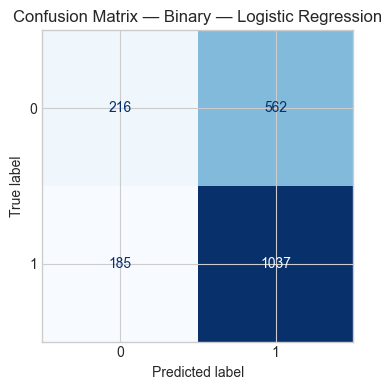


===== Binary — Random Forest =====
CV Accuracy (mean ± std): 0.6288 ± 0.0099
CV F1_macro (mean ± std): 0.5641 ± 0.0121
Test Accuracy : 0.6275
Test F1_macro : 0.5551
Confusion Matrix (test):
[[ 224  554]
 [ 191 1031]]


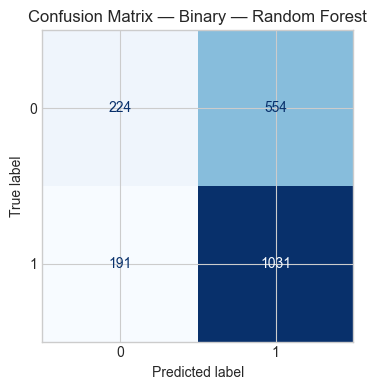

In [543]:
# Drop rows with missing target
# Prepare binary target
bin_mask = train[TARGET_BIN].notna()
X_bin = X_full.loc[bin_mask].copy()
y_bin_raw = train.loc[bin_mask, TARGET_BIN]

# Align test features to training columns (in case of extra cols)
if y_test_bin is not None:
    test_mask = y_test_bin.notna()
    X_test_bin = X_test_full.loc[test_mask].copy()
    y_test_bin_raw = y_test_bin.loc[test_mask]
else:
    X_test_bin = X_test_full.copy()
    y_test_bin_raw = None

le_bin = LabelEncoder()
y_bin = le_bin.fit_transform(y_bin_raw.astype(str))

if y_test_bin_raw is not None:
    y_test_bin = le_bin.transform(y_test_bin_raw.astype(str))
else:
    y_test_bin = None

# Model 1: Logistic Regression (binary)
logreg_bin = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ]
)

# Model 2: Random Forest (binary)
rf_bin = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
        )),
    ]
)

binary_results = []

if y_test_bin is not None:
    binary_results.append(
        run_classification_cv_and_test(
            pipe=logreg_bin,
            X_train=X_bin,
            y_train=y_bin,
            X_test=X_test_bin,
            y_test=y_test_bin,
            name="Binary — Logistic Regression",
        )
    )

    binary_results.append(
        run_classification_cv_and_test(
            pipe=rf_bin,
            X_train=X_bin,
            y_train=y_bin,
            X_test=X_test_bin,
            y_test=y_test_bin,
            name="Binary — Random Forest",
        )
    )

- Logistic Regression and Random Forest perform almost identically.

- Test accuracy around 0.63 and F1-macro around 0.55 indicate moderate predictive power, but also reflect:

- Class imbalance or subtle feature differences between classes

- Some predictors may not strongly separate diabetic vs. non-diabetic patients

- The PCA-based model performed worse, confirming that:

- Important information is being lost when reducing dimensions.

- PCA is not always beneficial for classification when original features hold meaningful structure.

#### Insight
Both LR and RF are capable of capturing the basic trends in the data, but the signal distinguishing diabetic vs. non-diabetic patients is not extremely strong, consistent with what we observed in the correlation heatmap (no very strong direct linear correlations).

### Multiclass Classification — diabetes_stage


===== Multiclass — Logistic Regression =====
CV Accuracy (mean ± std): 0.6060 ± 0.0127
CV F1_macro (mean ± std): 0.1840 ± 0.0101
Test Accuracy : 0.6055
Test F1_macro : 0.1747
Confusion Matrix (test):
[[   0    0    0    0    4]
 [   0    0   16    0  127]
 [   0    6   45    0  584]
 [   0    0    0    0    1]
 [   0    2   49    0 1166]]


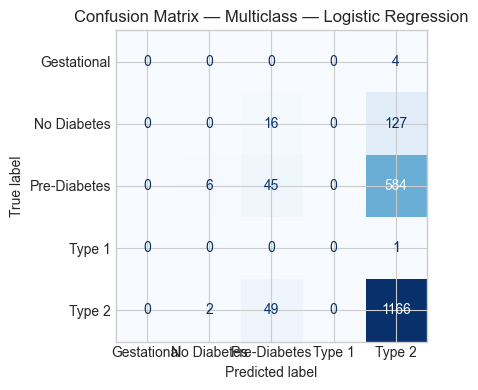


===== Multiclass — Random Forest =====
CV Accuracy (mean ± std): 0.6014 ± 0.0029
CV F1_macro (mean ± std): 0.1810 ± 0.0042
Test Accuracy : 0.6065
Test F1_macro : 0.1817
Confusion Matrix (test):
[[   0    0    0    0    4]
 [   0    0   19    0  124]
 [   0    0   62    0  573]
 [   0    0    0    0    1]
 [   0    0   66    0 1151]]


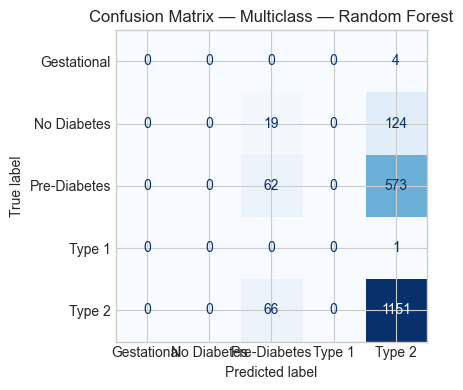

In [544]:
multi_mask = train[TARGET_MULTI].notna()
X_multi = X_full.loc[multi_mask].copy()
y_multi = train.loc[multi_mask, TARGET_MULTI]

X_test_multi = X_test_full.copy()

# Model 3: Logistic Regression (multinomial)
logreg_multi = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(
            max_iter=2000,
            random_state=RANDOM_STATE,
        )),
    ]
)

# Model 4: Random Forest (multiclass)
rf_multi = Pipeline(
    steps=[
        ("prep", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
        )),
    ]
)

multiclass_results = []

if y_test_multi is not None:
    multiclass_results.append(
        run_classification_cv_and_test(
            pipe=logreg_multi,
            X_train=X_multi,
            y_train=y_multi,
            X_test=X_test_multi,
            y_test=y_test_multi,
            name="Multiclass — Logistic Regression",
        )
    )

    multiclass_results.append(
        run_classification_cv_and_test(
            pipe=rf_multi,
            X_train=X_multi,
            y_train=y_multi,
            X_test=X_test_multi,
            y_test=y_test_multi,
            name="Multiclass — Random Forest",
        )
    )
else:
    print("\n[WARNING] Multiclass target not found in test set, skipping multiclass test evaluation.")

- Accuracy is around 0.60, similar to binary classification.

- However, F1-macro is extremely low (~0.18).

This implies:

- The model is predicting the majority class well but struggles with minority classes.

- Diabetes stages may not be cleanly separable using the available clinical features.

- Stage categories may be ordinal or continuous-like, but treated as discrete multiclass labels, making prediction harder.

#### Insight
Imbalanced stage distribution or overlapping feature patterns likely explain the poor F1. This aligns with the correlation analysis, where several features correlate only moderately with diabetes risk, not sharply enough to separate fine-grained stage labels.

### Regression — diabetes_risk_score


===== Regression — Random Forest =====
CV MSE (mean ± std): 2.7099 ± 0.1262
CV R²  (mean ± std): 0.9663 ± 0.0012
Test MSE : 2.3707
Test R²  : 0.9697


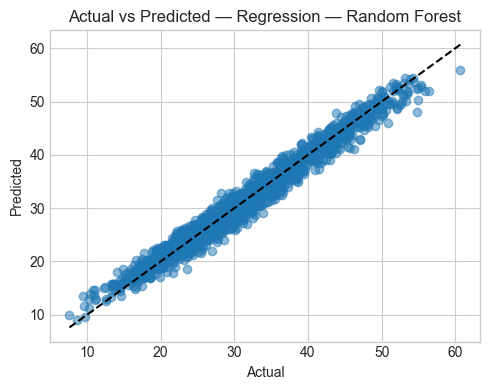

In [545]:
reg_mask = train[TARGET_REG].notna()
X_reg = X_full.loc[reg_mask].copy()
y_reg = train.loc[reg_mask, TARGET_REG]

X_test_reg = X_test_full.copy()


reg_rf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("reg", RandomForestRegressor(
            n_estimators=300,
            random_state=RANDOM_STATE,
        )),
    ]
)

regression_results = []

if y_test_reg is not None:
    regression_results.append(
        run_regression_cv_and_test(
            pipe=reg_rf,
            X_train=X_reg,
            y_train=y_reg,
            X_test=X_test_reg,
            y_test=y_test_reg,
            name="Regression — Random Forest",
        )
    )
else:
    print("\n[WARNING] Regression target not found in test set, skipping regression test evaluation.")

#### This model performs exceptionally well, explaining ~97% of the variance in diabetes risk score.

This is consistent with the heatmap:

- Age, BMI, waist-to-hip ratio, cholesterol, systolic BP, and screen time all show moderate positive correlations (0.25–0.52).

- Physical activity shows a moderate negative correlation (−0.35).

These relationships are strong enough for a non-linear model like Random Forest to reconstruct the risk score with high precision.

#### Insight

Unlike classification tasks—which must capture discrete boundaries—regression directly learns the continuous relationship among risk factors, providing much better performance.

### Dimension Reduction with PCA (for binary classification example)


===== Binary — Logistic Regression + PCA(10) =====
CV Accuracy (mean ± std): 0.6158 ± 0.0084
CV F1_macro (mean ± std): 0.4962 ± 0.0071
Test Accuracy : 0.6120
Test F1_macro : 0.4778
Confusion Matrix (test):
[[ 105  673]
 [ 103 1119]]


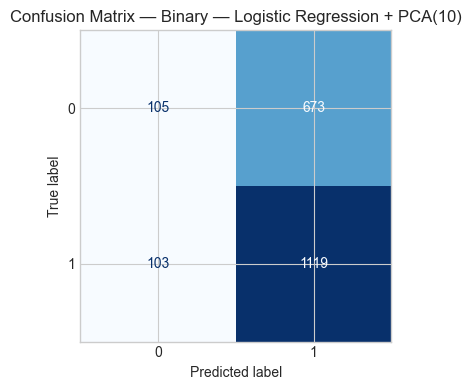

In [546]:
pca_components = 10 

logreg_bin_pca = Pipeline(
    steps=[
        ("prep", preprocess),
        ("pca", PCA(n_components=pca_components, random_state=RANDOM_STATE)),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ]
)

pca_results = []

if y_test_bin is not None:
    pca_results.append(
        run_classification_cv_and_test(
            pipe=logreg_bin_pca,
            X_train=X_bin,
            y_train=y_bin,
            X_test=X_test_bin,
            y_test=y_test_bin,
            name=f"Binary — Logistic Regression + PCA({pca_components})",
        )
    )
else:
    print("\n[WARNING] Binary target not in test set, skipping PCA test evaluation.")

### PCA Visualization (2D scatter)

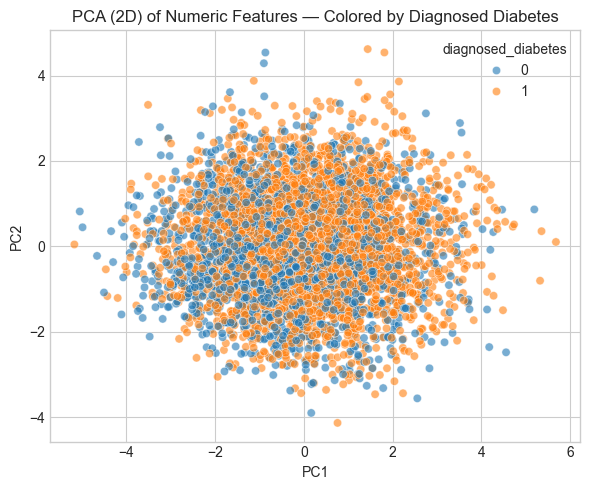

In [547]:
if TARGET_BIN in train.columns:
    numeric_data = train.loc[bin_mask, num_cols].copy()

    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(numeric_data)

    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    pca_scores = pca2.fit_transform(numeric_scaled)

    pca_df = pd.DataFrame(
        pca_scores,
        columns=["PC1", "PC2"],
    )

    pca_df[TARGET_BIN] = y_bin

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=pca_df,
        x="PC1",
        y="PC2",
        hue=TARGET_BIN,
        alpha=0.6,
    )
    plt.title("PCA (2D) of Numeric Features — Colored by Diagnosed Diabetes")
    plt.tight_layout()
    plt.show()


A PCA projection (2 components) revealed:

- No clean separation between diabetic and non-diabetic classes.

- Overlap in PCA space suggests non-linear boundaries or weak linear separability.

This corroborates the moderate binary classification accuracy and indicates why PCA-based LR performed worse.

In [548]:


if binary_results or pca_results:
    bin_all = binary_results + pca_results
    df_bin = pd.DataFrame(bin_all)
    print("\n=== Binary Classification Models Summary ===")
    print(df_bin)

if multiclass_results:
    df_multi = pd.DataFrame(multiclass_results)
    print("\n=== Multiclass Classification Models Summary ===")
    print(df_multi)

if regression_results:
    df_reg = pd.DataFrame(regression_results)
    print("\n=== Regression Models Summary ===")
    print(df_reg)



=== Binary Classification Models Summary ===
                                     name  cv_accuracy_mean  cv_accuracy_std  \
0            Binary — Logistic Regression            0.6294         0.007710   
1                  Binary — Random Forest            0.6288         0.009867   
2  Binary — Logistic Regression + PCA(10)            0.6158         0.008424   

   cv_f1_macro_mean  cv_f1_macro_std  test_accuracy  test_f1_macro  
0          0.564829         0.009607         0.6265       0.550806  
1          0.564088         0.012146         0.6275       0.555058  
2          0.496239         0.007095         0.6120       0.477758  

=== Multiclass Classification Models Summary ===
                               name  cv_accuracy_mean  cv_accuracy_std  \
0  Multiclass — Logistic Regression            0.6060         0.012681   
1        Multiclass — Random Forest            0.6014         0.002871   

   cv_f1_macro_mean  cv_f1_macro_std  test_accuracy  test_f1_macro  
0          0.18

## Summary

### Data Exploration summary

In [549]:
print(f"""Data preparation summary:
- {number_of_fixed} typos fixed across 5 features: smoking_status, diabetes_stage, education_level, family_history_diabetes, diagnosed_diabetes
- {number_of_filled} missing values (with medians by groups and modes)filled across 7 features: family_history_diabetes, gender, smoking_status, diabetes_stage, physical_activity_minutes_per_week, sleep_hours_per_day, systolic_bp
- {number_of_replaced} replaced (with medians) values across 3 features: alcohol_consumption_per_week, diet_score, cholesterol_total""")

Data preparation summary:
- 6 typos fixed across 5 features: smoking_status, diabetes_stage, education_level, family_history_diabetes, diagnosed_diabetes
- 8 missing values (with medians by groups and modes)filled across 7 features: family_history_diabetes, gender, smoking_status, diabetes_stage, physical_activity_minutes_per_week, sleep_hours_per_day, systolic_bp
- 4 replaced (with medians) values across 3 features: alcohol_consumption_per_week, diet_score, cholesterol_total


### Correlation analysis summary

1. Age strongly correlates with systolic BP(0.53), cholesterol(0.28), and diabetes risk score (0.52).
Hence, older patients have higher metabolic and cardiovascular risk factors.

2. Physical activity has a moderate negative correlation with diabetes risk score (−0.35).
Hence, active lifestyles reduce diabetes risk.

3. BMI and waist-to-hip ratio positively correlate with diabetes risk score (0.32 and 0.25).
Hence, obesity indicators remain strong predictors.

4. Cholesterol and systolic BP show moderate positive correlations with diabetes risk score (0.2 and 0.35).
Hence, cardiometabolic factors cluster together.

### Modelling summary

Binary Classification

- Logistic Regression and Random Forest achieved ~0.63 accuracy and ~0.55 F1.
- Moderate ability to detect diabetic status from clinical indicators.
- Feature information loss because PCA made the performance worse

Multiclass Classification

- ~0.60 accuracy but ~0.18 F1-macro.
- Severe class imbalance and difficulty distinguishing between diabetes stages.
- Stages may require more granular, clinical, or longitudinal data.

Regression

- Random Forest Regression performed exceptionally well (~0.97 R2).
- Risk score is highly predictable from available features.
- Supported by correlation analysis (heatmap)

### General summary

The most influential factors for diabetes risk appear to be:

- Age
- BMI & waist-to-hip ratio
- Systolic blood pressure
- Cholesterol
- Physical activity level

According to the dataset. It also aligns with clinical expectations and experiences.

The dataset is not linearly separable (shown in PCA). It limits classification performance.

Non-linear interactions are detected because Random Forest models consistently outperform linear models in regression and classification